In [1]:
import pandas as pd
import numpy as np
import fastsparsegams
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import time

In [2]:
### input parameters for plots, info about MICE

In [8]:
num_trials = 2

In [9]:
subset_seed=1
subset = False #'no_external'#f'Random_seed={subset_seed}'
subset_size=5

added_missingness_seed = 1
added_missingness_num_cols = 1
added_missingness_rate = 0.2
added_missingness = f'mnar_pro_aug_{added_missingness_num_cols}_random_cols_{added_missingness_rate}_missingness_rate'

### Dataset Loading

In [10]:
df = pd.read_csv('./fico_full.csv')

In [11]:
if subset: 
    if 'Random' in subset: 
        np.random.seed(subset_seed)
        cols = df.columns[list(np.random.choice(df.shape[1]-1, 5, replace=False)) + [-1]]
        df = df[cols]
    elif 'no_external' in subset:
        cols = list(set(df.columns) - set(['ExternalRiskEstimate']))
        df = df[cols]
    else: 
        df = df[df.columns[[-9, -5, -4, -3, -2, -1]]] #highest missingness prop

In [12]:
if added_missingness:
    np.random.seed(added_missingness_seed)
    if 'random_col' in added_missingness:
        target_cols = np.random.choice(df.shape[1]-1, added_missingness_num_cols, replace=False)
    
    if 'mnar_pro_aug' in added_missingness:
        inter_cols = np.random.choice(df.shape[1]-1, added_missingness_num_cols, replace=False)
        targets = np.random.choice([0, 1], size=(df.shape[0], target_cols.shape[0]), p=[1-added_missingness_rate, added_missingness_rate])
        
        for i, col in enumerate(target_cols):
            print(f"Adding missingness to: {df.columns[col]}")
            thresh_col = df.columns[inter_cols[i]]
            thresh_mask = df[thresh_col] >= df[thresh_col].quantile(0.6)
            tartget_labels = np.zeros_like(thresh_mask)
            tartget_labels[thresh_mask] = 1
            mask = (targets[:, i] == 1) & (df['PoorRiskPerformance'] == tartget_labels)
            df.loc[mask, df.columns[col]] = -10
        
    elif 'mnar' in added_missingness:
        targets = np.random.choice([0, 1], size=(df.shape[0], target_cols.shape[0]), p=[1-added_missingness_rate, added_missingness_rate])
        
        for i, col in enumerate(target_cols):
            print(f"Adding missingness to: {df.columns[col]}")
            mask = (targets[:, i] == 1) & (df['PoorRiskPerformance'] == 1)
            df.loc[mask, df.columns[col]] = -10
        

Adding missingness to: NumRevolvingTradesWBalance


In [13]:
df['NumSatisfactoryTrades']

0        20
1         2
2         9
3        28
4        12
         ..
10454    21
10455    11
10456    18
10457    42
10458     4
Name: NumSatisfactoryTrades, Length: 10459, dtype: int64

In [14]:
for c in df.columns:
    print(f"Missing rate for {c}", df[df[c] <= -7].shape[0] / df[c].shape[0])

Missing rate for PercentTradesWBalance 0.057940529687350605
Missing rate for ExternalRiskEstimate 0.057175638206329475
Missing rate for MSinceOldestTradeOpen 0.07907065685055932
Missing rate for MSinceMostRecentTradeOpen 0.056219523855053063
Missing rate for AverageMInFile 0.056219523855053063
Missing rate for NumSatisfactoryTrades 0.056219523855053063
Missing rate for NumTrades60Ever2DerogPubRec 0.056219523855053063
Missing rate for NumTrades90Ever2DerogPubRec 0.056219523855053063
Missing rate for PercentTradesNeverDelq 0.056219523855053063
Missing rate for MSinceMostRecentDelq 0.5189788698728368
Missing rate for MaxDelq2PublicRecLast12M 0.056219523855053063
Missing rate for MaxDelqEver 0.056219523855053063
Missing rate for NumTotalTrades 0.056219523855053063
Missing rate for NumTradesOpeninLast12M 0.056219523855053063
Missing rate for PercentInstallTrades 0.056219523855053063
Missing rate for MSinceMostRecentInqexcl7days 0.27908977913758487
Missing rate for NumInqLast6M 0.05621952385

### Utility functions for running experiments

In [15]:
def binarize_according_to_train(train_df, test_df, overall_mi_intercept = True, overall_mi_ixn = True, specific_mi_intercept = True, specific_mi_ixn = True):
    n_train, d_train = train_df.shape
    n_test, d_test = test_df.shape
    train_binned, train_augmented_binned, test_binned, test_augmented_binned = {}, {}, {}, {}
    train_no_missing, test_no_missing = {}, {}
    for c in train_df.columns:
        if c == 'PoorRiskPerformance':
            continue
        missing_col_name = f'{c} missing'
        missing_row_train = np.zeros(n_train)
        missing_row_test = np.zeros(n_test)
        for v in list(train_df[c].quantile([0.2, 0.4, 0.6, 0.8, 1]).unique()) + [-7, -8, -9, 10]:
            if v in [-7, -8, -9, -10]:

                if specific_mi_intercept:
                    new_col_name = f'{c} == {v}'
    
                    new_row_train = np.zeros(n_train)
                    new_row_train[train_df[c] == v] = 1
                    train_binned[new_col_name] = new_row_train
                    train_augmented_binned[new_col_name] = new_row_train
                    
                    new_row_test = np.zeros(n_test)
                    new_row_test[test_df[c] == v] = 1
                    test_binned[new_col_name] = new_row_test
                    test_augmented_binned[new_col_name] = new_row_test

                missing_row_train[train_df[c] == v] = 1
                missing_row_test[test_df[c] == v] = 1
            else:
                new_col_name = f'{c} <= {v}'

                new_row_train = np.zeros(n_train)
                new_row_train[train_df[c] <= v] = 1
                train_no_missing[new_col_name] = new_row_train
                train_binned[new_col_name] = new_row_train
                train_augmented_binned[new_col_name] = new_row_train
                
                new_row_test = np.zeros(n_test)
                new_row_test[test_df[c] <= v] = 1
                test_no_missing[new_col_name] = new_row_test
                test_binned[new_col_name] = new_row_test
                test_augmented_binned[new_col_name] = new_row_test

        if overall_mi_intercept: 
            train_binned[missing_col_name] = missing_row_train
            train_augmented_binned[missing_col_name] = missing_row_train
        
            test_binned[missing_col_name] = missing_row_test
            test_augmented_binned[missing_col_name] = missing_row_test
    
    for c_outer in train_df.columns:
        if c_outer == 'PoorRiskPerformance':
            continue
        for c_inner in train_df.columns:
            for v in train_df[c_inner].quantile([0.2, 0.4, 0.6, 0.8, 1]).unique():
                if (v in [-7, -8, -9, -10]) or c_inner == 'PoorRiskPerformance':
                    continue
                else:
                    missing_ixn_name = f'{c_outer} missing & {c_inner} <= {v}'
                    missing_ixn_row_train = np.zeros(n_train)
                    missing_ixn_row_test = np.zeros(n_test)
                    for m_val in [-7, -8, -9, -10]:
                        if specific_mi_ixn: 
                            new_col_name = f'{c_outer}_missing_{m_val} & {c_inner} <= {v}'
    
                            new_row_train = np.zeros(n_train)
                            new_row_train[(train_df[c_outer] == m_val) & (train_df[c_inner] <= v)] = 1
                            train_augmented_binned[new_col_name] = new_row_train
    
                            new_row_test = np.zeros(n_test)
                            new_row_test[(test_df[c_outer] == m_val) & (test_df[c_inner] <= v)] = 1
                            test_augmented_binned[new_col_name] = new_row_test

                        missing_ixn_row_train[(train_df[c_outer] == m_val) & (train_df[c_inner] <= v)] = 1
                        missing_ixn_row_test[(test_df[c_outer] == m_val) & (test_df[c_inner] <= v)] = 1

                    if overall_mi_ixn: 
                        train_augmented_binned[missing_ixn_name] = missing_ixn_row_train
                        test_augmented_binned[missing_ixn_name] = missing_ixn_row_test
                        
    train_binned['PoorRiskPerformance'] = train_df['PoorRiskPerformance']
    test_binned['PoorRiskPerformance'] = test_df['PoorRiskPerformance']
    train_no_missing['PoorRiskPerformance'] = train_df['PoorRiskPerformance']
    test_no_missing['PoorRiskPerformance'] = test_df['PoorRiskPerformance']
    train_augmented_binned['PoorRiskPerformance'] = train_df['PoorRiskPerformance']
    test_augmented_binned['PoorRiskPerformance'] = test_df['PoorRiskPerformance']
    return pd.DataFrame(train_no_missing), pd.DataFrame(train_binned), pd.DataFrame(train_augmented_binned), \
         pd.DataFrame(test_no_missing), pd.DataFrame(test_binned), pd.DataFrame(test_augmented_binned)

In [16]:
#recover coefficients and train/test probabilities
def eval_model(model, X_train, X_test, col_names): 
    coeffs = np.zeros((len(model.lambda_0[0]), X_train.shape[1]))
    missing_coeffs = np.zeros((len(model.lambda_0[0])))
    inter_coeffs = np.zeros((len(model.lambda_0[0])))
    train_probs = np.zeros((len(model.lambda_0[0]), X_train.shape[0]))
    test_probs = np.zeros((len(model.lambda_0[0]), X_test.shape[0]))

    for i, lamby in enumerate(model.lambda_0[0]): 
        train_probs[i] = model.predict(X_train.astype(float),lambda_0=lamby).reshape(-1)
        test_probs[i] = model.predict(X_test.astype(float),lambda_0=lamby).reshape(-1)

        cur_col_names = col_names[(model.coeff(lambda_0=lamby).toarray().flatten()[1:] != 0)]
        missing_coeffs[i] = sum(['-' in c for c in cur_col_names])
        inter_coeffs[i] = sum(['&' in c for c in cur_col_names])
        coeffs[i] = (model.coeff(lambda_0=lamby).toarray().flatten())[1:] #first entry is intercept
    return train_probs, test_probs, coeffs, missing_coeffs, inter_coeffs

### Running Trials

0
1


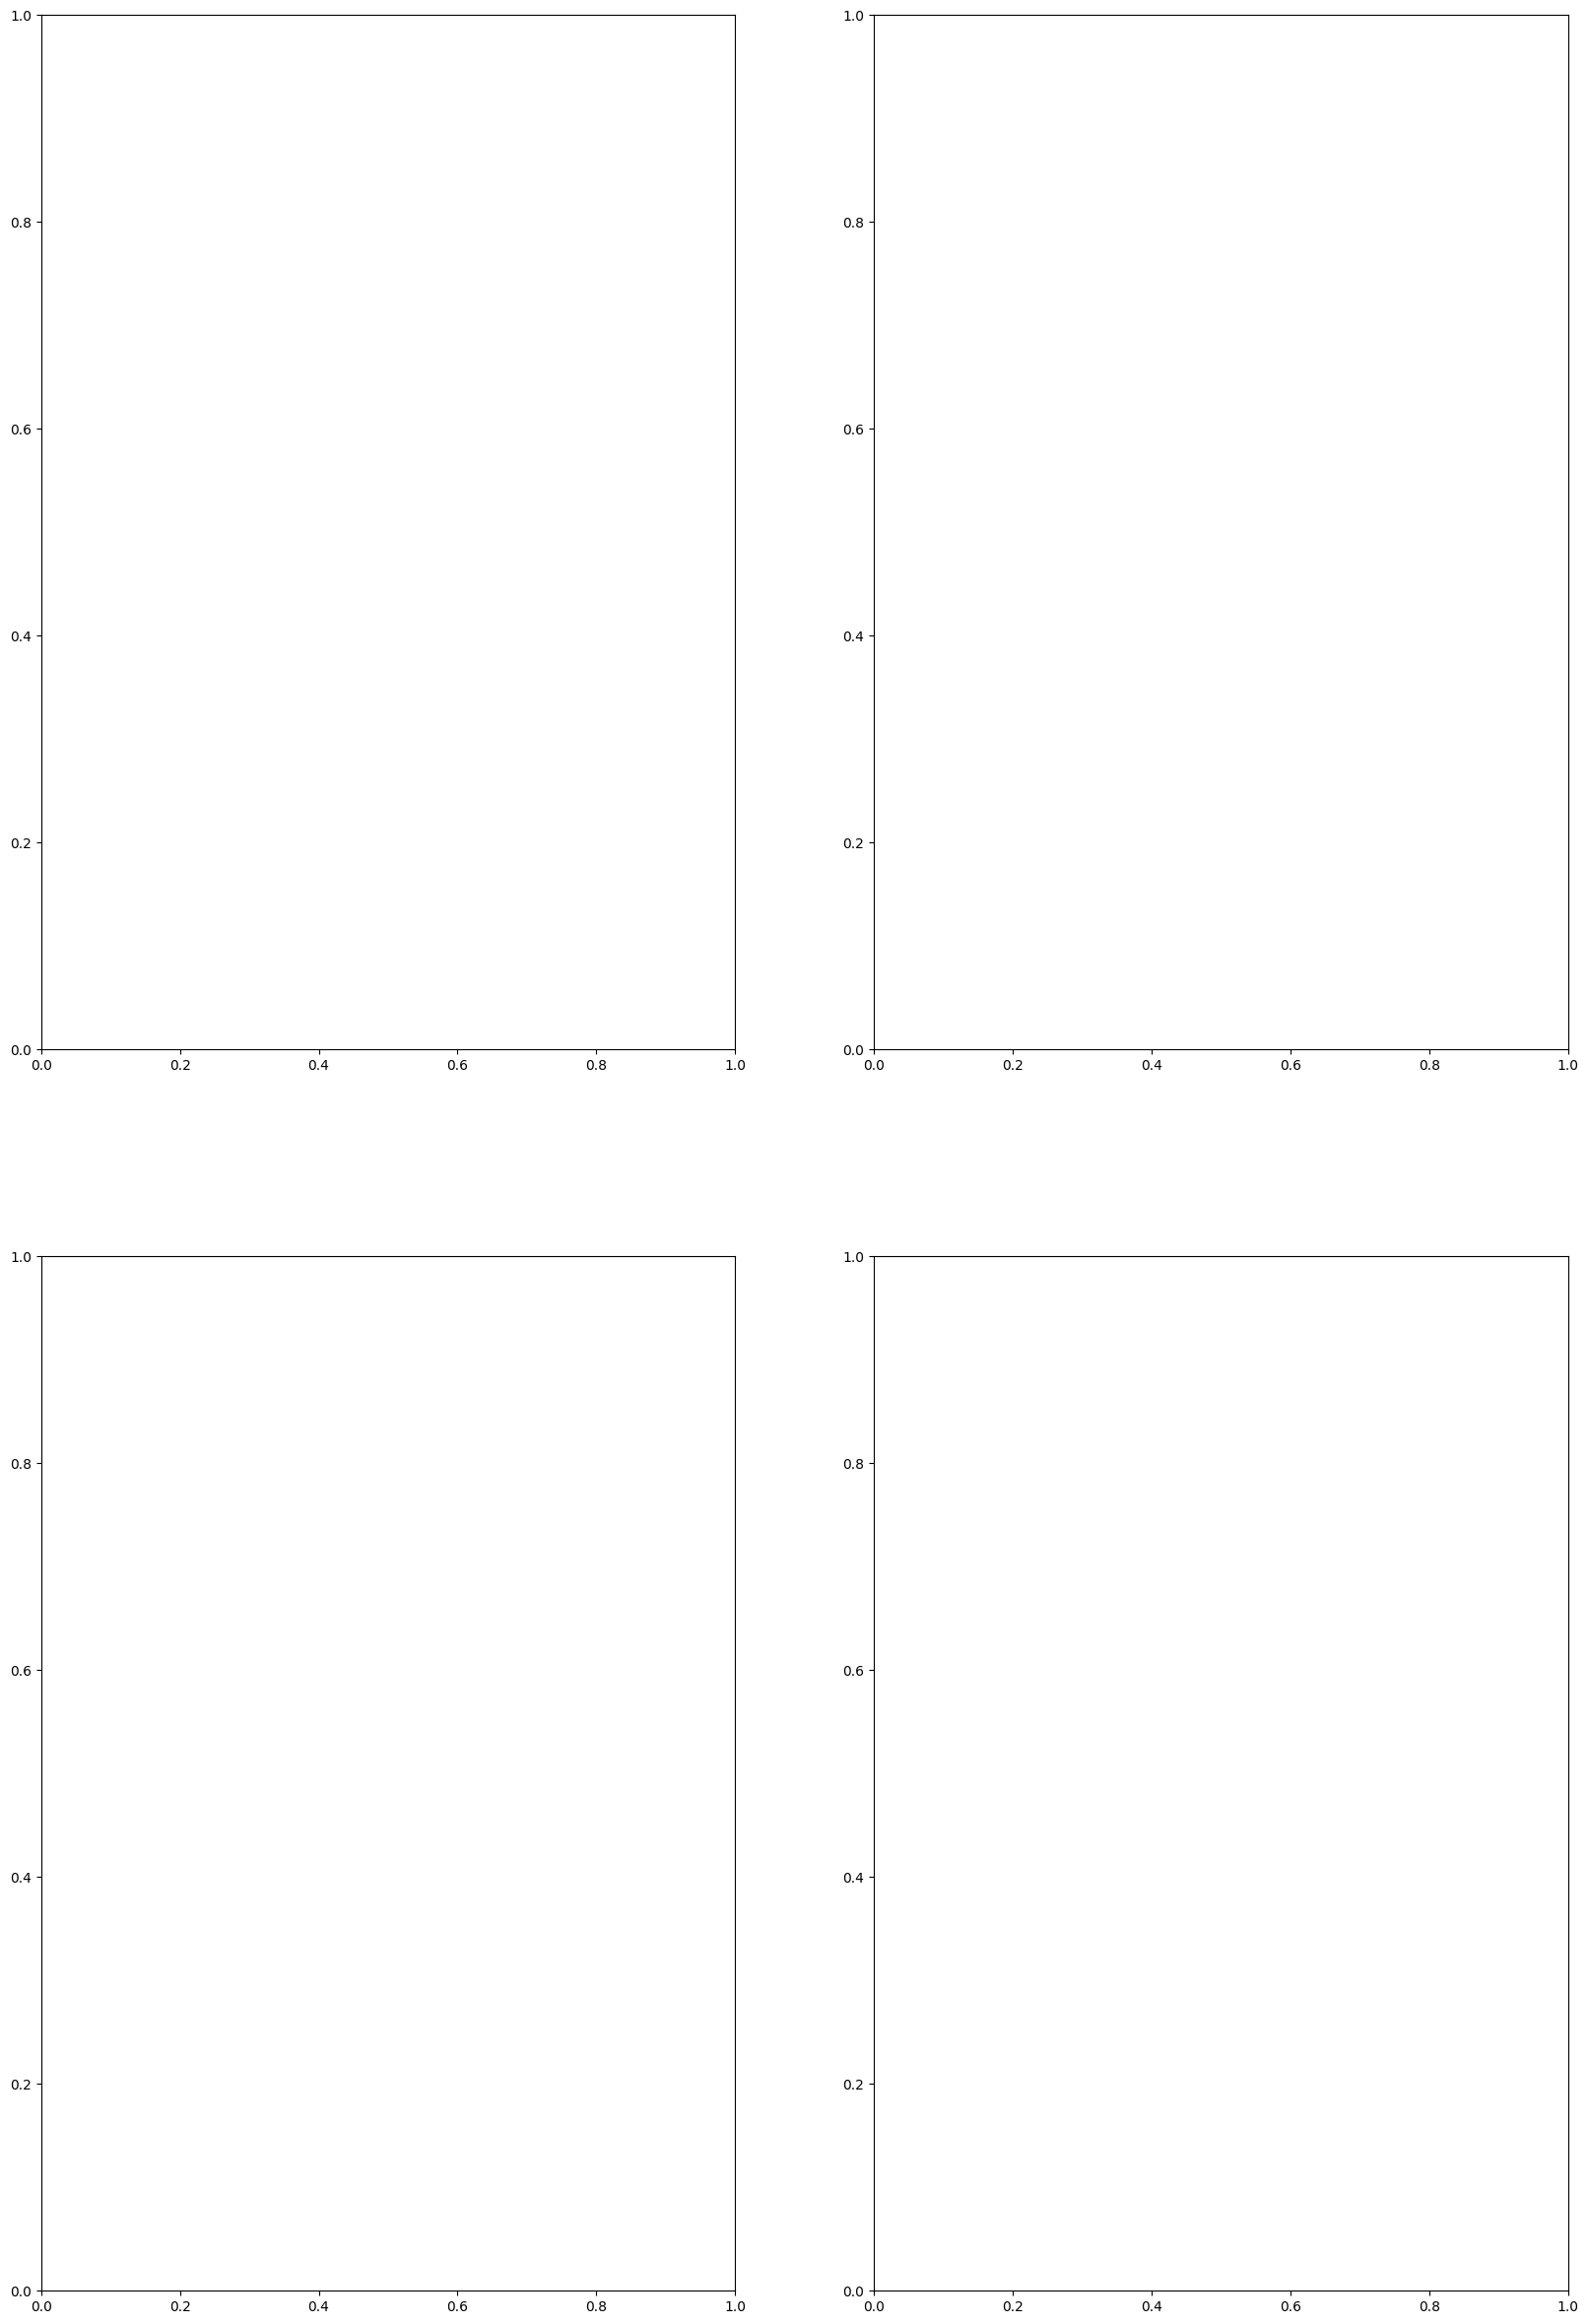

In [18]:
num_terms_aug_all, num_terms_indicator_all, num_terms_no_missing_all = [],[],[]
trainacc_no_missing_all, trainacc_indicator_all, trainacc_aug_all = [],[],[]
testacc_no_missing_all, testacc_indicator_all, testacc_aug_all = [],[],[]

for idx in range(0, num_trials): 
    print(idx)

    # set up train/test sets for our 3 settings: no missingness, missingness intercept, missingness interaction
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=idx, stratify=df['PoorRiskPerformance'])
    train_no_missing, train_binned, train_binned_augmented, test_no_missing, test_binned, test_binned_augmented = binarize_according_to_train(train_df, test_df)
    X_indicator_train = train_binned[train_binned.columns[:-1]].values
    y_train = train_binned['PoorRiskPerformance'].values
    X_indicator_test = test_binned[test_binned.columns[:-1]].values
    y_test = test_binned['PoorRiskPerformance'].values
    X_no_missing_train = train_no_missing[train_no_missing.columns[:-1]].values
    X_no_missing_test = test_no_missing[test_no_missing.columns[:-1]].values
    X_aug_train = train_binned_augmented[train_binned_augmented.columns[:-1]].values
    X_aug_test = test_binned_augmented[test_binned_augmented.columns[:-1]].values

    # run fastsparse on these 3 datasets
    model_aug = fastsparsegams.fit(X_aug_train.astype(float), y_train.astype(int)*2 - 1, loss="Exponential", max_support_size=40, algorithm="CDPSI")
    model_indicator = fastsparsegams.fit(X_indicator_train.astype(float), y_train.astype(int)*2 - 1, loss="Exponential", max_support_size=40, algorithm="CDPSI")
    model_no_missing = fastsparsegams.fit(X_no_missing_train.astype(float), y_train.astype(int)*2 - 1, loss="Exponential", max_support_size=40, algorithm="CDPSI")

    # evaluate models
    train_probs_aug, test_probs_aug, coeff_aug, missing_coeff_aug, inter_coeffs = eval_model(model_aug, X_aug_train, 
                                                                            X_aug_test, train_binned_augmented.columns[:-1])
    trainacc_aug = ((train_probs_aug > 0.5) == y_train).mean(axis = 1)
    testacc_aug = ((test_probs_aug > 0.5) == y_test).mean(axis = 1)
    num_terms_aug = (coeff_aug != 0).sum(axis=1)

    train_probs_indicator, test_probs_indicator, coeff_indicator, missing_coeff_indicator, _ = eval_model(model_indicator, 
                                                                                                    X_indicator_train, 
                                                                                                    X_indicator_test,
                                                                                                    train_binned.columns[:-1])
    trainacc_indicator = ((train_probs_indicator > 0.5) == y_train).mean(axis=1)
    testacc_indicator = ((test_probs_indicator > 0.5) == y_test).mean(axis=1)
    num_terms_indicator = (coeff_indicator != 0).sum(axis=1)

    train_probs_no_missing, test_probs_no_missing, coeff_no_missing, missing_coeff_no_missing, _ = eval_model(model_no_missing, X_no_missing_train, X_no_missing_test, train_no_missing.columns[:-1])
    trainacc_no_missing = ((train_probs_no_missing > 0.5) == y_train).mean(axis=1)
    testacc_no_missing = ((test_probs_no_missing > 0.5) == y_test).mean(axis=1)
    num_terms_no_missing = (coeff_no_missing != 0).sum(axis=1)

    num_terms_aug_all.append(num_terms_aug)
    num_terms_indicator_all.append(num_terms_indicator)
    num_terms_no_missing_all.append(num_terms_no_missing)

    trainacc_no_missing_all.append(trainacc_no_missing) 
    trainacc_indicator_all.append(trainacc_indicator)
    trainacc_aug_all.append(trainacc_aug)
    
    testacc_no_missing_all.append(testacc_no_missing)
    testacc_indicator_all.append(testacc_indicator)
    testacc_aug_all.append(testacc_aug)



In [25]:
testacc_no_missing_all = np.concatenate(testacc_no_missing_all)

In [26]:
num_terms_aug_all = np.concatenate(num_terms_aug_all)
num_terms_indicator_all = np.concatenate(num_terms_indicator_all)
num_terms_no_missing_all = np.concatenate(num_terms_no_missing_all)

trainacc_no_missing_all = np.concatenate(trainacc_no_missing_all)
trainacc_indicator_all = np.concatenate(trainacc_indicator_all)
trainacc_aug_all = np.concatenate(trainacc_aug_all)

testacc_indicator_all = np.concatenate(testacc_indicator_all)
testacc_aug_all = np.concatenate(testacc_aug_all)

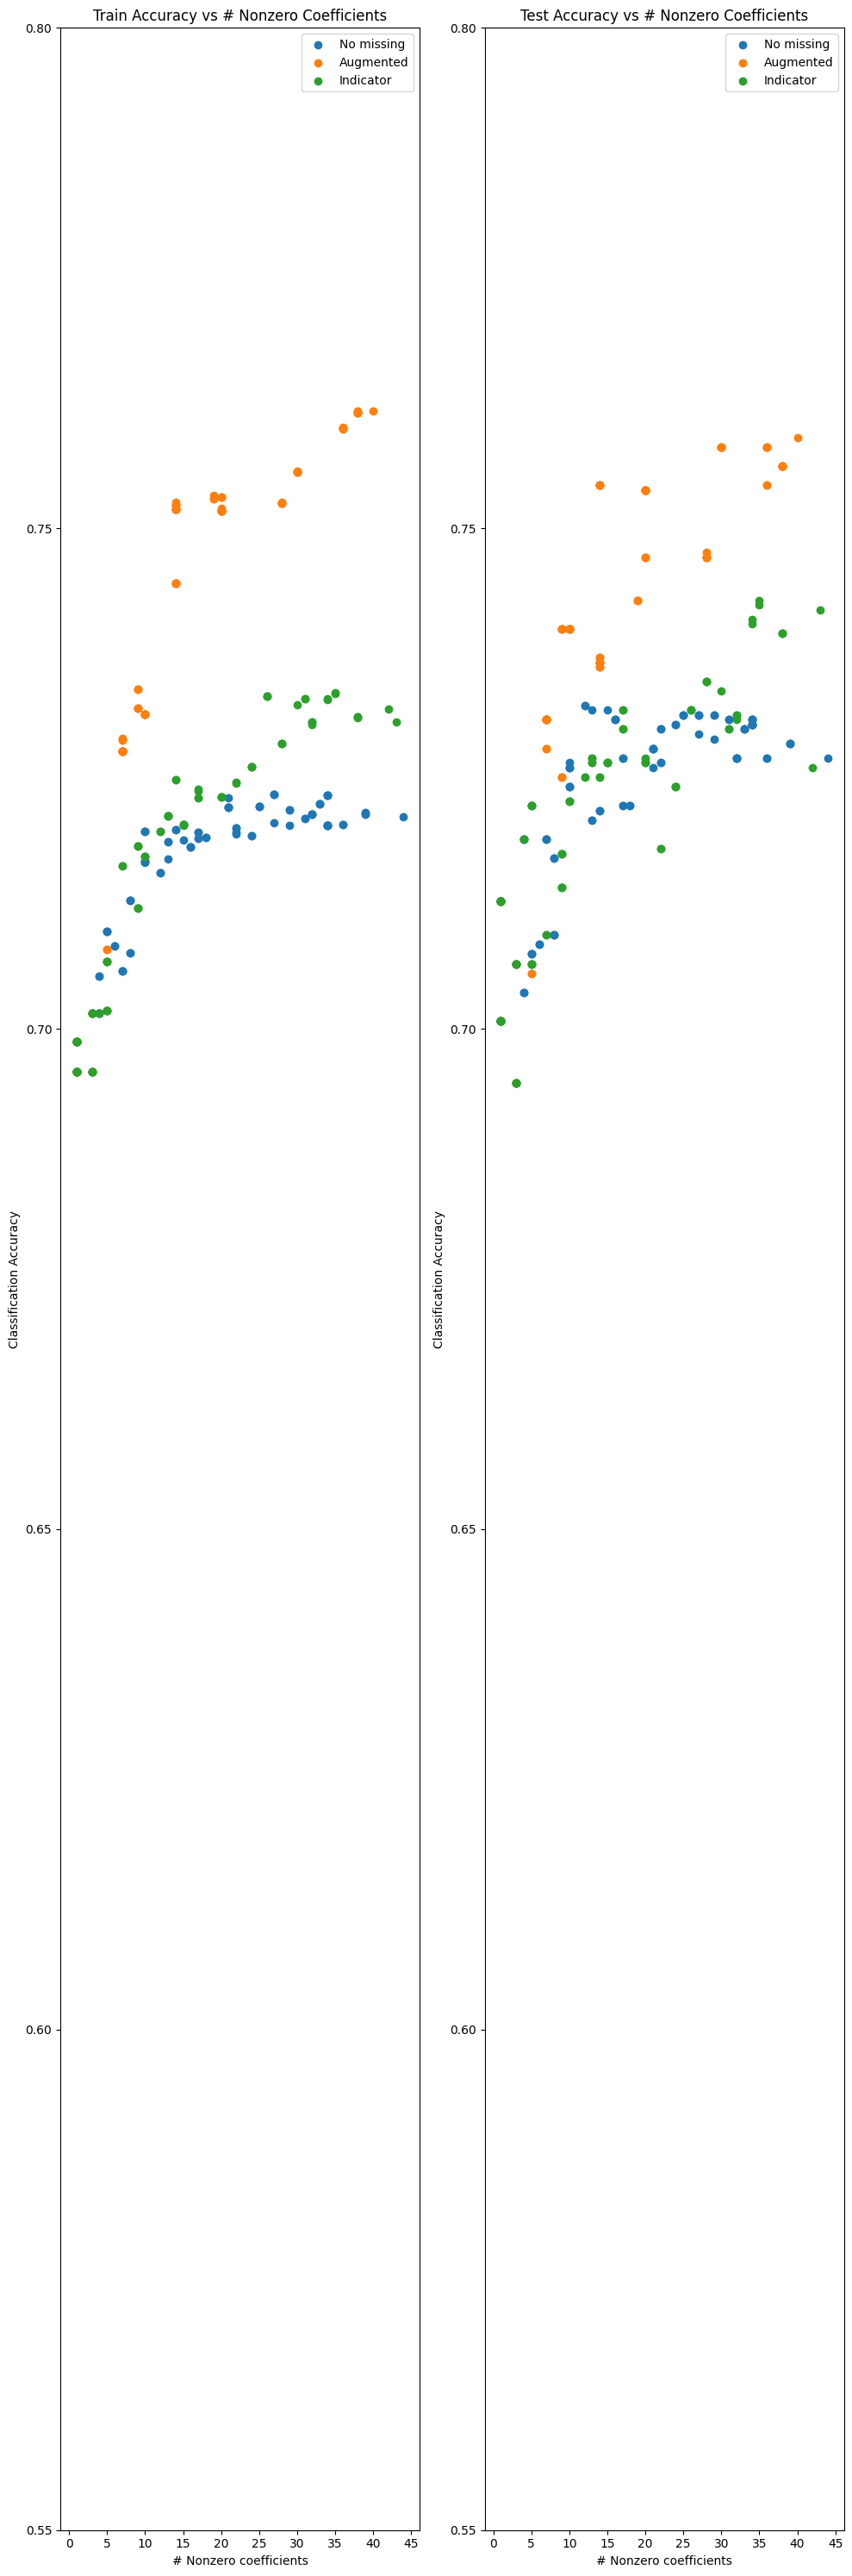

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(10, 30))

ax = axs[0]
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.set_title('Train Accuracy vs # Nonzero Coefficients')#\n (Other than intercept)
ax.scatter(num_terms_no_missing_all[num_terms_no_missing_all > 0], trainacc_no_missing_all[num_terms_no_missing_all > 0], label='train accuracy, no missing')
ax.scatter(num_terms_aug_all[num_terms_aug_all > 0], trainacc_aug_all[num_terms_aug_all > 0], label='train accuracy, interaction')
ax.scatter(num_terms_indicator_all[num_terms_indicator_all > 0], trainacc_indicator_all[num_terms_indicator_all > 0], label='train accuracy, only indicator')
ax.set_ylabel('Classification Accuracy')
ax.set_xlabel('# Nonzero coefficients')
ax.set_ylim([0.55, max(0.8, max(trainacc_aug))])
ax.legend(['No missing', 'Augmented', 'Indicator'])

ax = axs[1]

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('Test Accuracy vs # Nonzero Coefficients')#\n (Other than intercept)
ax.scatter(num_terms_no_missing_all[num_terms_no_missing_all > 0], testacc_no_missing_all[num_terms_no_missing_all > 0], label='test accuracy, no missing')
ax.scatter(num_terms_aug_all[num_terms_aug_all > 0], testacc_aug_all[num_terms_aug_all > 0], label='test accuracy, interaction')
ax.scatter(num_terms_indicator_all[num_terms_indicator_all > 0], testacc_indicator_all[num_terms_indicator_all > 0], label='test accuracy, only indicator')
ax.set_ylabel('Classification Accuracy')
ax.set_xlabel('# Nonzero coefficients')
ax.set_ylim([0.55, max(0.8, max(testacc_aug))])
ax.legend(['No missing', 'Augmented', 'Indicator'])

fig.tight_layout()

plt.savefig(f'figs/Nov/train_test_additive_missingness_subset={subset}_added_missingness={added_missingness}.png')

In [108]:
with open(f'figs/Nov/train_test_additive_missingness_subset={subset}_added_missingness={added_missingness}.txt', 'w') as outfile: 
    for c in df.columns:
        outfile.write(f"Missing rate for {c}" + str(df[df[c] <= -7].shape[0] / df[c].shape[0]) + '\n')